In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
  !git config --global user.email "naiaseh@uwo.com"
  !git config --global user.name "Nadia Aiaseh"

In [3]:
import os
os.chdir("/content/drive/MyDrive/Trunk/PinnNew")
print(os.getcwdb())

b'/content/drive/MyDrive/Trunk/PinnNew'


In [ ]:
!git add KP.ipynb
!git commit -m "KP.ipynb"
!git push

In [3]:
from modules.models import KPPinn, create_dense_model, create_dense_model_Normalized, FourierFeatures
from modules.data import simulate_KP
from modules.plots import plot_KdV_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import imageio

In [4]:

phi = 0



def boundary_function(txy):
    return phi*tf.ones_like(txy[:, 1:2])




In [45]:
angle = np.pi/180. * 60.
ampl = 1.5
one = (np.tan(angle) - np.sqrt(2*ampl))/2
two = one + np.sqrt(2*ampl)
k1 = np.min([one, two])
k2 = np.max([one, two])
print(k1, k2)

-2.220446049250313e-16 1.732050807568877


In [32]:
### KPII ###

### original single-soliton phi-fcn ###
# def phi_function1(txy):
#   delta_1, delta_2 = 0., 0.
#   # ksi = 1/2 * ((k2-k1)*txy[:,1:2] + (k1**2 - k2**2)*txy[:,2:3] + (k2**3 - k1**3)*txy[:,0:1] + delta_1 - delta_2)
#   # u = (k2-k1)**2 / (2*tf.cosh(ksi)**2)+phi
#   alpha = - 30. * np.pi/180.
#   c = 3.
#   b = tf.tan(alpha)
#   ksi = txy[:,1:2] - b * txy[:,2:3] - c*txy[:,0:1] + delta_1
#   u = c/(2*tf.cosh(tf.sqrt(c)/2 * ksi)**2)

#   u = tf.where(tf.math.is_nan(u), 0., u)
#   return u

def phi_function1(txy):
    c = 3.
    angle_y_axis = (-30*np.pi/180)
    offset =  +12
    lamb = 2*tf.tan(angle_y_axis)
    kappa = tf.sqrt(c/4)
    ksi = txy[:, 1:2] + lamb*txy[:,2:3] - (c+3*lamb**2) * txy[:,0:1] + offset
    u = c / (2*tf.cosh(kappa*(ksi))**2)+phi
    u = tf.where(tf.math.is_nan(u), 0., u)
    return u

### NOTES ####
# c/2 = 2k^2
# lamb = 2*tf.tan(angle_y_axis) where angle_y_axis is CCW from the positive y axis.

x_start =  -20. #-10
length = 20.#10
y_start = x_start
ylength = length
t0 = 0.
time = 7.

# def phi_function(txy):

#   k1 = 1/2
#   k2 = 0.
#   c = k1**2*4
#   c2 = k2**2*4
#   k3 = np.sqrt(2.8/4)
#   angle_y_axis = (60.*np.pi/180)
#   angle_y_axis2 = (60.*np.pi/180)
#   angle_y_axis3 = (0.*np.pi/180)

#   # for X config
#   offset =  22.
#   offset2 =  22.
#   offset3 =  +12.

#   # for Y xonfig
#   vert_offset1, vert_offset2 = 0., 0.
#   # offset, offset2, offset3 = 0., 0., 0.,


#   lamb = 2.*tf.tan(angle_y_axis) # if this is negative it'll be CW
#   lamb2 = 0.
#   lamb3 = 0.
#   eta1 = k1*((txy[:, 1:2] + offset) + lamb * (txy[:,2:3] + vert_offset1) - (k1**2+3*lamb**2) *txy[:,0:1] )
#   eta2 = k2*((txy[:, 1:2] + offset2) + lamb2 * (txy[:,2:3] + vert_offset2) - (k2**2+3*lamb2**2) * txy[:,0:1])
#   eta3 = k3*(txy[:, 1:2] + lamb3*txy[:,2:3] - (k3**2+3*lamb3**2) * txy[:,0:1]) + offset3


#   eA12 =( (k1-k2)**2 - (lamb-lamb2)**2)/((k1+k2)**2 - (lamb-lamb2)**2)
#   # eA23 =( (k2-k3)**2 - (lamb2-lamb3)**2)/((k2+k3)**2 - (lamb2-lamb3)**2)

#   deriv_term1 = (k1**2 * tf.math.exp(eta1) + k2**2 * tf.math.exp(eta2) + eA12 * (k1+k2)**2 * tf.math.exp(eta1+eta2)) / (1 + tf.math.exp(eta1) + tf.math.exp(eta2) + eA12 * tf.math.exp(eta1+eta2))
#   deriv_term2 = (k1 * tf.math.exp(eta1) + k2 * tf.math.exp(eta2) + eA12 * (k1+k2) * tf.math.exp(eta1+eta2))**2 / (1 + tf.math.exp(eta1) + tf.math.exp(eta2) + eA12 * tf.math.exp(eta1+eta2))**2

#   u2 = 2*(deriv_term1 - deriv_term2)
#   u2 = tf.where(tf.math.is_nan(u2), 0., u2)

#   return u2

### KPI ###

# def phi_function(txy):


#     lamb = 0
#     mu = 1
#     kappa = tf.sqrt(c/4) # c/2 = 2k^2
#     numer = -(txy[:, 1:2] + lamb*txy[:,2:3] + 3*(lamb**2-mu**2) * txy[:,0:1])**2 + mu**2 * (txy[:,2:3] + 6*lamb*txy[:,0:1])**2 + 1/mu**2
#     denom = ((txy[:, 1:2] + lamb*txy[:,2:3] + 3*(lamb**2-mu**2) * txy[:,0:1])**2 + mu**2 * (txy[:,2:3] + 6*lamb*txy[:,0:1])**2 + 1/mu**2)**2
#     u = numer/denom
#     u = tf.where(tf.math.is_nan(u), 0., u)
#     return u
# x_start =  -10. #-10
# length = 10.#10
# y_start = -10
# ylength = 10
# time =  3

In [20]:
def phi_function3(txy):

  a1 = -1.
  a2 = -2.
  a3 = -3.
  c = a1**2*4
  c2 = a2**2*4


  offset =  0.
  offset2 =  0.
  offset3 =  0.
  vert_offset = 0.
  lamb = 1/3 # if this is negative it'll be CW
  lamb2 = 2/3
  lamb3 = 5/3
  theta1 = a1*((txy[:, 1:2] + offset) + lamb * (txy[:,2:3] + vert_offset) - (a1**2+3*lamb**2) *txy[:,0:1] )
  theta2 = a2*((txy[:, 1:2] + offset2) + lamb2 * (txy[:,2:3] + vert_offset) - (a2**2+3*lamb2**2) * txy[:,0:1])
  theta3 = a3*((txy[:, 1:2] + offset3) + lamb3 * (txy[:,2:3] + vert_offset) - (a3**2+3*lamb3**2) * txy[:,0:1])

  A12 =( (a1-a2)**2 - (lamb-lamb2)**2)/((a1+a2)**2 - (lamb-lamb2)**2)
  A13 =( (a1-a3)**2 - (lamb-lamb3)**2)/((a1+a3)**2 - (lamb-lamb3)**2)
  A23 =( (a2-a3)**2 - (lamb2-lamb3)**2)/((a2+a3)**2 - (lamb2-lamb3)**2)
  A = A12*A13*A23


  F = 1 + tf.math.exp(2*theta1) + tf.math.exp(2*theta2) + tf.math.exp(2*theta3) + A12*tf.math.exp(2*(theta1 + theta2)) + A13*tf.math.exp(2*(theta1 + theta3)) + \
  A23*tf.math.exp(2*(theta2 + theta3)) + A*tf.math.exp(2*(theta1 + theta2 + theta3))

  Fprimeprime = 4*a1**2 * tf.math.exp(2*theta1) + 4*a2**2 * tf.math.exp(2*theta2) + 4*a3**2 * tf.math.exp(2*theta3) + \
  (2*a1 + 2*a2)**2 * A12*tf.math.exp(2*(theta1 + theta2)) + (2*a1 + 2*a3)**2 * A13*tf.math.exp(2*(theta1 + theta3)) + \
  (2*a2 + 2*a3)**2 * A23*tf.math.exp(2*(theta2 + theta3)) + (2*a1 + 2*a2 + 2*a3)**2 * A*tf.math.exp(2*(theta1 + theta2 + theta3))

  Fprime = 2*a1* tf.math.exp(2*theta1) + 2*a2* tf.math.exp(2*theta2) + 2*a3* tf.math.exp(2*theta3) +\
  (2*a1+2*a2) * A12*tf.math.exp(2*(theta1 + theta2)) + (2*a1 + 2*a3) * A13*tf.math.exp(2*(theta1 + theta3)) + \
  (2*a2 + 2*a3) * A23*tf.math.exp(2*(theta2 + theta3)) + 2*(a1+a2+a3) * A*tf.math.exp(2*(theta1 + theta2 + theta3))

  u = 2*Fprimeprime/F - 2* (Fprime/F)**2

  u = tf.where(tf.math.is_nan(u), 0., u)
  u = tf.where(tf.math.is_inf(u), 0., u)
  return u

x_start =  -30. #-10
length = 30.#10
y_start = x_start
ylength = length
time = 3.
t0 = 0.


(300, 3)
my shape tf.Tensor([90000     1], shape=(2,), dtype=int32) tf.Tensor([300 300], shape=(2,), dtype=int32)


Text(0.5, 1.0, 'wave cross section at y = 0')

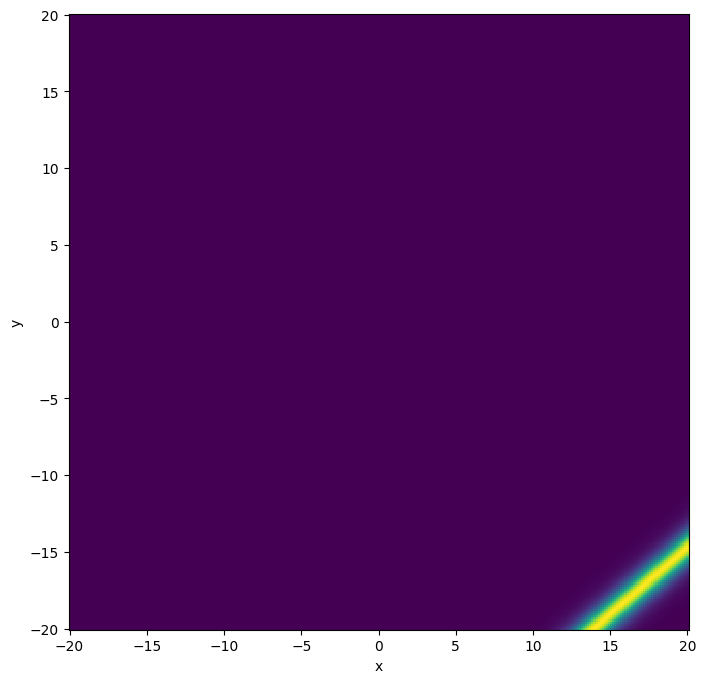

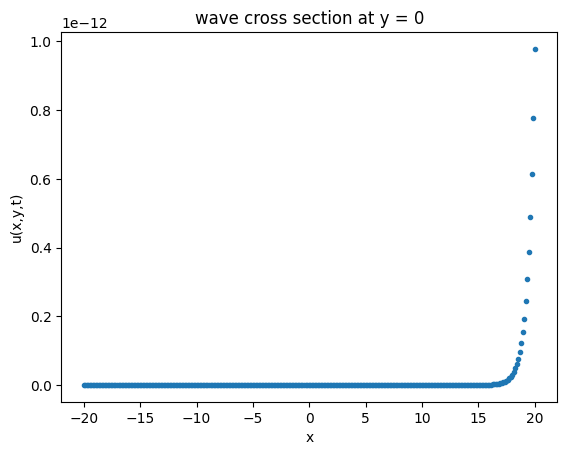

In [35]:
from matplotlib.gridspec import GridSpec
N = 300
TIME = time
xt = np.linspace(x_start,length,N).T
yt = np.linspace(y_start,ylength,N).T
tt = np.zeros((N,1))
xt = xt.reshape(-1,1)
yt = yt.reshape(-1,1)
tt = tt.reshape(-1,1)

txy_test = np.c_[tt,xt,yt]
print(txy_test.shape)
txy_test = tf.convert_to_tensor(txy_test, dtype = 'float32')
txy_test = tf.reshape(txy_test, [N,3])

x, y = np.meshgrid(xt, yt)
txy = np.stack([np.full(x.flatten().shape, TIME), x.flatten(), y.flatten()],axis=-1)
fig = plt.figure(figsize=(8,8))

gs = GridSpec(1, 1)
plt.subplot(gs[0, 0])

ut = phi_function1(txy)
print('my shape',tf.shape(ut), tf.shape(x))
ut = tf.reshape(ut, [x.shape[0],x.shape[1]])
plt.pcolormesh(x, y, ut)
plt.xlabel('x')
plt.ylabel('y')
# cbar = plt.colorbar(pad=0.05, aspect=10)
# cbar.set_label('u(t,x)')
# cbar.mappable.set_clim( tf.reduce_min(ut), tf.reduce_max(ut))
# cbar.mappable.set_clim( 0.02, 0.4)
fig = plt.figure()

cross_sect = 0

txy2 = np.stack([np.full(tt.shape, TIME),  xt , np.full(tt.shape, cross_sect)], axis=1)
u2 = phi_function1(txy2)
u2 = tf.reshape(u2, [xt.shape[0],xt.shape[1]])
plt.plot(xt, u2, '.',label = 'exact at time {}'.format(0))

plt.xlabel('x')
plt.ylabel('u(x,y,t)')
plt.title('wave cross section at y = {}'.format(cross_sect))

In [85]:
### Plotting some test function in Fourier space ###
# # N = 6000
# x_flat = np.linspace(-20,20,N)
# Sin = np.sin(np.pi*x_flat) + 1/2*np.sin(np.pi*25*x_flat) + 1/3*np.sin(np.pi*50*x_flat) + 1/4*np.sin(np.pi*60*x_flat)
# kappa2= 2*np.pi/(40*np.pi)*np.arange(-N/2,N/2,1) # define frequencies, from -N/2 to N/2, from negative to positive
# kappa3=np.fft.fftshift(kappa2)
# Sin_fft = tf.signal.fft(tf.cast(u2, tf.complex128))
# # Sin_fft = tf.signal.fft(Sin)
# plt.semilogy( kappa3[1:N//2] , np.abs(Sin_fft)[1:N//2],'.') # index for positive coefficients

# plt.xlabel('frequency (k)')
# plt.ylabel('$F_k$')

In [36]:
# when boundary function is set to None, the data will be collected from the phi_function but at boundary
(txy_eqn, u_eqn), (txy_init, u_phi), (txy_boundary_x, u_bnd_x), (txy_boundary_y, u_bnd_y), (x_bnd_left, x_bnd_right), (y_bnd_left, y_bnd_right)  = simulate_KP(50000, phi_function1, None, time, x_start, length, y_start, ylength, n_bnds = None,\
                                                                                                                                                               n_init = None, tstart = t0, random_seed = 42, dtype=tf.float32)

In [37]:
normalizer = tf.keras.layers.Normalization(axis=1)
normalizer.adapt(txy_eqn)
# normalizer = FourierFeatures(n_features=25, standard_dev = 5.)
# normalizer.build(input_shape=[3])


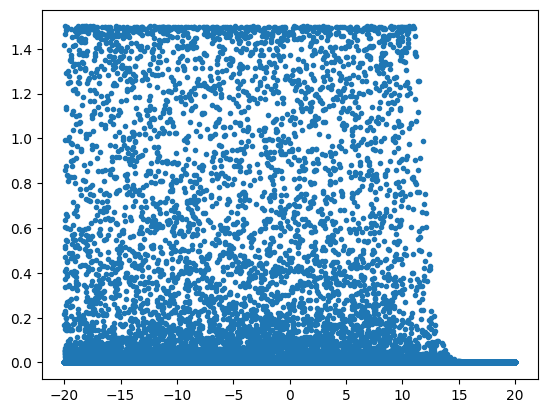

In [38]:
# plt.plot(txy_boundary_x[:,1:2],u_bnd_x,'.')

plt.plot(txy_init[:,1:2],u_phi,'.')

inputs = [txy_eqn, txy_init, txy_boundary_x, x_bnd_right, x_bnd_left, txy_boundary_y, y_bnd_right, y_bnd_left]
outputs = [phi_function1(txy_eqn), u_eqn, u_phi, u_bnd_x, u_bnd_y]


In [20]:
print(tf.shape(txy_eqn))

tf.Tensor([50000     3], shape=(2,), dtype=int32)


In [41]:
### another network structure that worked well was [12, 24, 24, 24, 12] ###
backbone = create_dense_model_Normalized([12, 24, 24, 24, 12] , activation= 'tanh', initializer='glorot_normal', \
    n_inputs=3, n_outputs=1, normalizer=normalizer)
pinn = KPPinn(backbone, k=6., sig_sq = +3., PBC_y = False)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.85)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
pinn.compile(optimizer=optimizer)

In [ ]:

with open('KPPinnTime15.pickle', 'rb') as f:
    my_weights = pickle.load(f)

pinn.backbone.set_weights(my_weights)

In [46]:
history = pinn.fit_custom(inputs, outputs, epochs = 10000, print_every = 500)
# history = pinn.fit(inputs, outputs, batch_size= 75000, epochs = 1200, verbose ='auto')

Epoch 0, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, Loss Boundary Y: 0.0000, MAE: 0.0006
Epoch 500, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, Loss Boundary Y: 0.0000, MAE: 0.0006
Epoch 1000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, Loss Boundary Y: 0.0000, MAE: 0.0006
Epoch 1500, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, Loss Boundary Y: 0.0000, MAE: 0.0006
Epoch 2000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, Loss Boundary Y: 0.0000, MAE: 0.0006
Epoch 2500, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, Loss Boundary Y: 0.0000, MAE: 0.0006
Epoch 3000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, Loss Boundary Y: 0.0000, MAE: 0.0006
Epoch 3500, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Boundary: 0.0000, Loss Boundary Y: 0.0000, MAE: 0.0006
Epoch 4000, Loss Residual: 0.0000, Loss Initial: 0.0000, Loss Bounda

In [ ]:
history


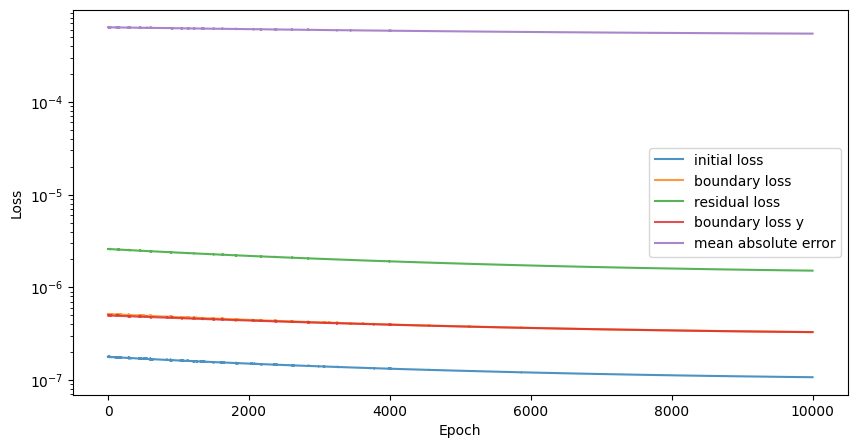

In [47]:
plot_training_loss(history, y_scale='log')

In [31]:
time

3.0

In [44]:
from matplotlib.gridspec import GridSpec
def plot_snapshots(timeList,num_test_samples = 200, phi_function = None, cross_sect = 0):

    x_flat = np.linspace(x_start, length, num_test_samples)
    y_flat = np.linspace(y_start, ylength, num_test_samples)
    t_flat = np.linspace(0, time, num_test_samples)
    x_flat = tf.convert_to_tensor(x_flat)
    y_flat = tf.convert_to_tensor(y_flat)
    t_flat = tf.convert_to_tensor(t_flat)

    t_cross_sections = timeList
    for i, t_cs in enumerate(t_cross_sections):
        x, y = np.meshgrid(x_flat, y_flat)
        txy = np.stack([np.full(x.flatten().shape, t_cs), x.flatten(), y.flatten()],axis=-1)


        fig = plt.figure(figsize=(7,4))
        gs = GridSpec(2, 5)
        plt.subplot(gs[0, :])

        u = pinn.backbone.predict(txy, batch_size=num_test_samples)
        u = u.reshape(x.shape)
        plt.pcolormesh(x, y, u)
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar(pad=0.05, aspect=10)
        cbar.set_label('u(t,x)')
        cbar.mappable.set_clim(0., 0.3)
        # cbar.mappable.set_clim(tf.reduce_min(u), tf.reduce_max(u))
        # plt.savefig(str(os.getcwdb())[2:-1]+"/GIFs/KPIIXJunctionTime15PDF/KPIIXJunction"+str(i)+".pdf", format="pdf", bbox_inches="tight")
        fig = plt.figure()
        txy2 = np.stack([np.full(t_flat.shape, t_cs),  x_flat , np.full(t_flat.shape, cross_sect)], axis=-1)


        u2 = pinn.backbone.predict(txy2, batch_size=num_test_samples)
        uexact = phi_function(txy2)
        # uexact = tf.reshape(uexact, [x_flat.shape[0],x_flat.shape[1]])
        plt.plot(x_flat, u2, label = 'Prediction at time {}'.format(t_cs))
        plt.plot(x_flat, uexact, '.',label = 'Exact at time {}'.format(t_cs))
        plt.xlabel('x')
        plt.ylabel('u(x,y,t)')
        plt.legend()
        plt.title('wave cross section at y = {}'.format(cross_sect))

    return u2, x_flat


1/1 [==============================] - 0s 16ms/step


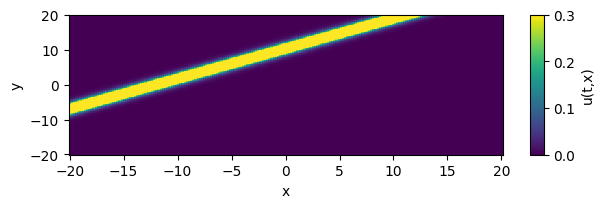

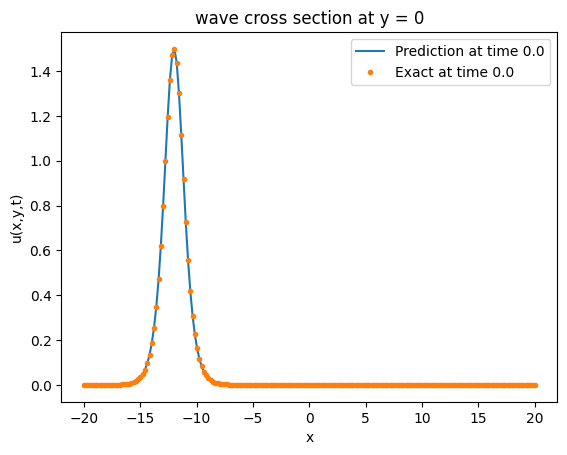

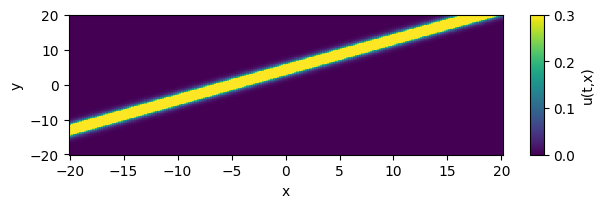

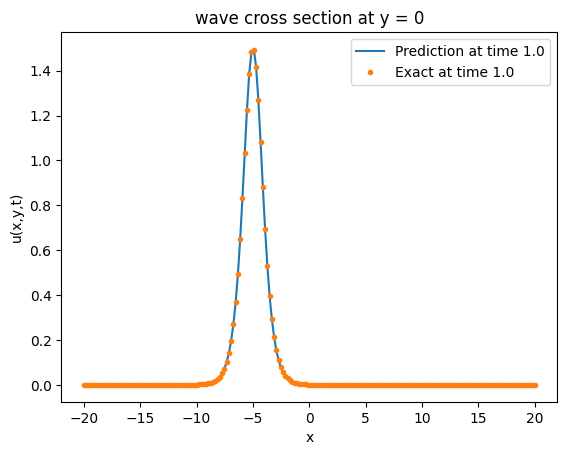

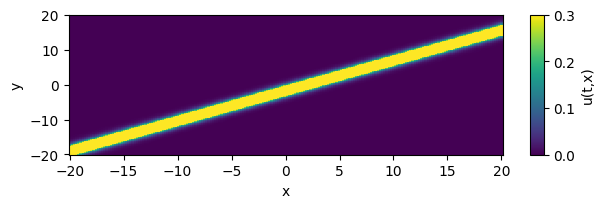

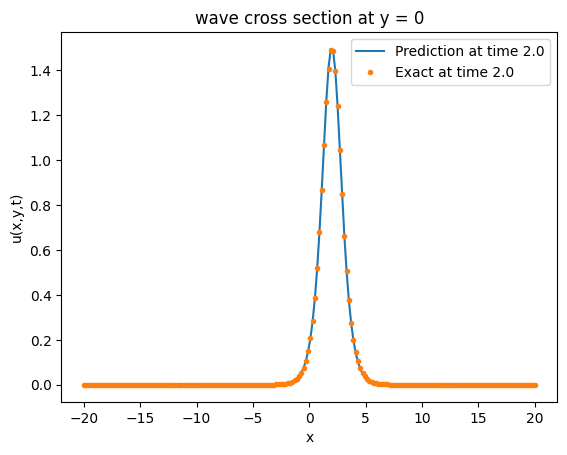

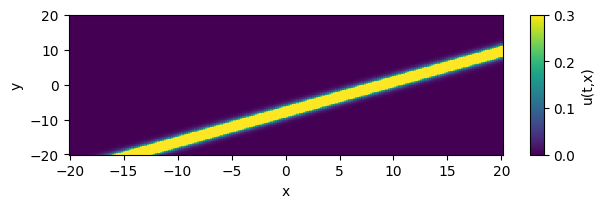

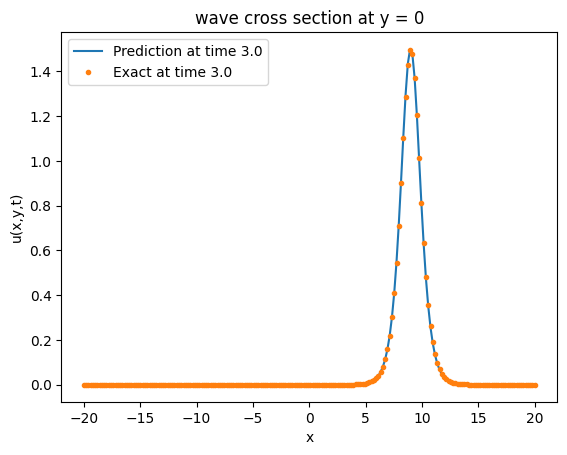

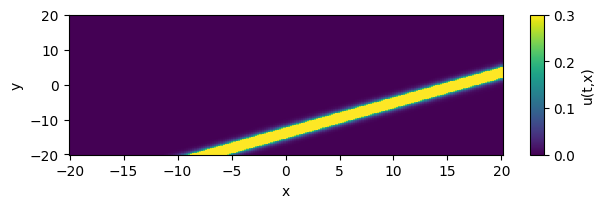

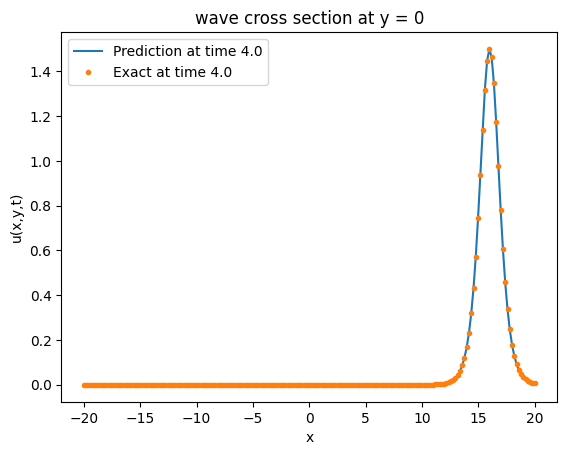

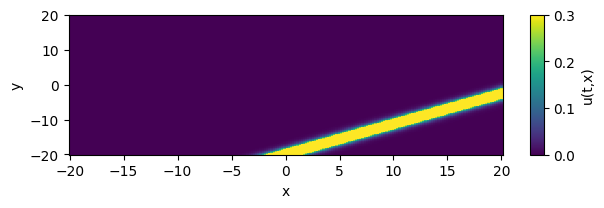

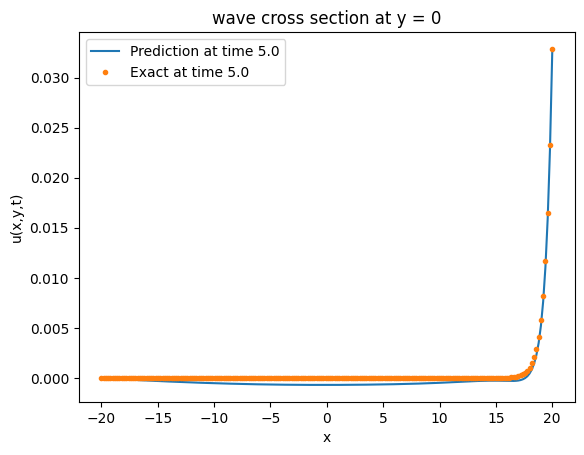

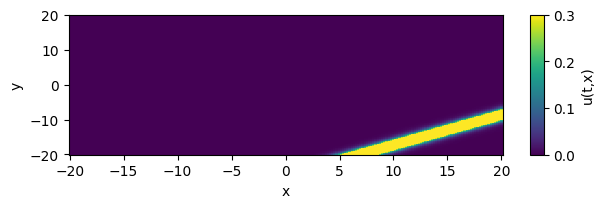

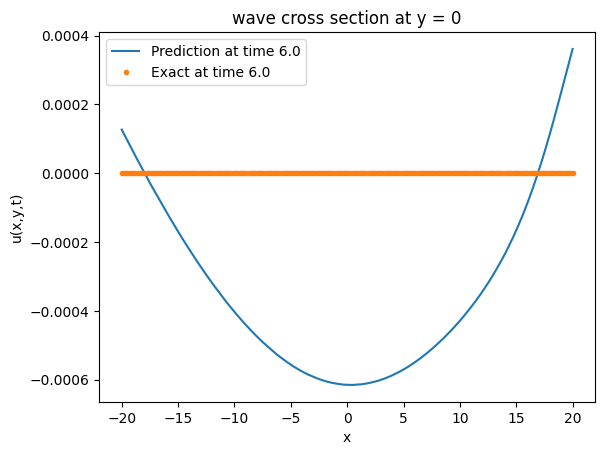

In [48]:

u2pinn, xpinn = plot_snapshots(np.arange(0,time,1), phi_function = phi_function1, cross_sect = 0)

In [ ]:
# put the images into the frames variable
import imageio
frames = []
timesGIF = np.arange(0,7+1,1)
for t, tt in enumerate(timesGIF):
    image = imageio.v2.imread(str(os.getcwdb())[2:-1]+"/GIFs/KPIIYJunctionTime7/KPIIYJunction"+str(t)+'.png')
    frames.append(image)
    print(t)


0
1
2
3
4
5
6
7


In [ ]:
# convert frames to GIF
GIFpath = str(os.getcwdb())[2:-1]+'/GIFs/YConfigKPII.gif'
imageio.mimsave(GIFpath, # output gif
                frames,          # array of input frames
                fps = 5)         # optional: frames per second

In [ ]:
import pickle
current_weights = pinn.backbone.get_weights()
with open('KPPinnTime15.pickle', 'wb') as f:
    pickle.dump(current_weights, f)

### seq-2-seq Attempt

Epoch 1/800
15/15 [==============================] - 34s 26ms/step - loss_total: 0.1662 - loss_residual: 8.5375e-04 - loss_initial: 0.0373 - loss_boundary: 0.0640 - loss_boundary_y: 0.0640 - mean_absolute_error: 0.1445
Epoch 2/800
15/15 [==============================] - 0s 24ms/step - loss_total: 0.0187 - loss_residual: 2.8022e-04 - loss_initial: 0.0030 - loss_boundary: 0.0078 - loss_boundary_y: 0.0076 - mean_absolute_error: 0.0491
Epoch 3/800
15/15 [==============================] - 0s 26ms/step - loss_total: 0.0086 - loss_residual: 2.5015e-04 - loss_initial: 0.0019 - loss_boundary: 0.0033 - loss_boundary_y: 0.0031 - mean_absolute_error: 0.0384
Epoch 4/800
15/15 [==============================] - 0s 23ms/step - loss_total: 0.0059 - loss_residual: 2.1773e-04 - loss_initial: 9.2619e-04 - loss_boundary: 0.0030 - loss_boundary_y: 0.0018 - mean_absolute_error: 0.0306
Epoch 5/800
15/15 [==============================] - 0s 27ms/step - loss_total: 0.0051 - loss_residual: 1.6675e-04 - loss_i

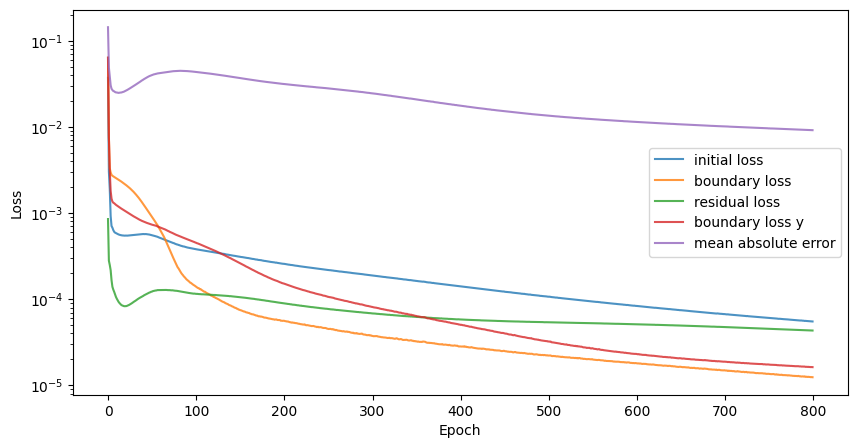

1/1 [==============================] - 0s 17ms/step


<Figure size 640x480 with 0 Axes>

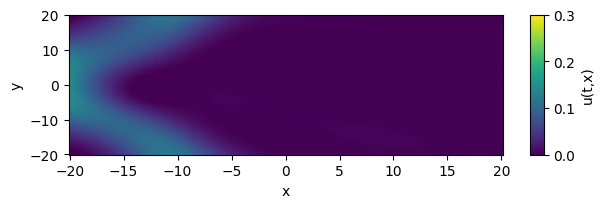

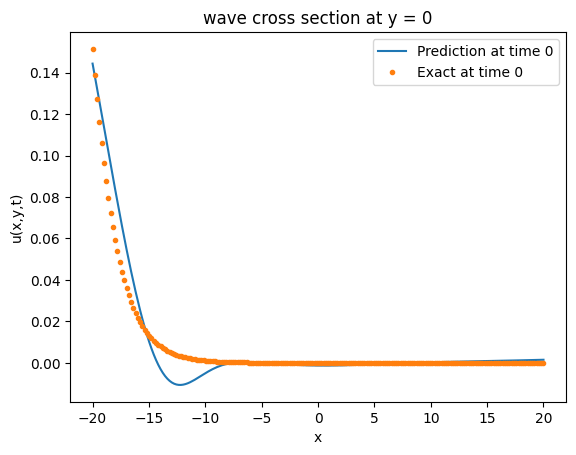

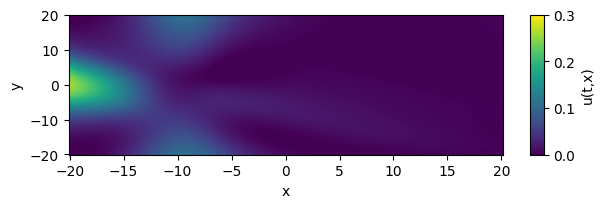

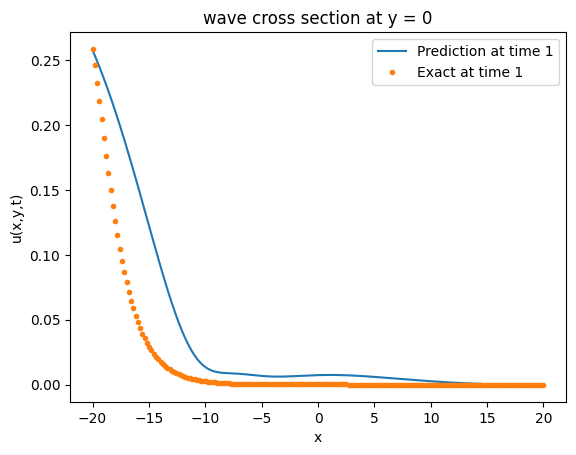

In [ ]:
# generate 75k for every time step till 0-1
# initialize pinn
# fit the pinn
# train for 500 epochs?
# save loss photos and weights
# change inputs and outputs
# go for the next time step.
x_start =  -20. #-10
length = 20.#10
y_start = x_start
ylength = length

time = 1
# when boundary function is set to None, the data will be collected from the phi_function but at boundary
(txy_eqn, u_eqn), (txy_init, u_phi), (txy_boundary_x, u_bnd_x), (txy_boundary_y, u_bnd_y), (x_bnd_left, x_bnd_right), (y_bnd_left, y_bnd_right)  = \
simulate_KP(75000, phi_function, None, time, x_start, length, y_start, ylength, n_bnds = None, n_init = None, random_seed = 42, dtype=tf.float32)
normalizer = tf.keras.layers.Normalization(axis=1)
normalizer.adapt(txy_eqn)

inputs = [txy_eqn, txy_init, txy_boundary_x, x_bnd_right, x_bnd_left, txy_boundary_y, y_bnd_right, y_bnd_left]
outputs = [phi_function(txy_eqn), u_eqn, u_phi, u_bnd_x, u_bnd_y]

backbone = create_dense_model_Normalized([12, 24, 24, 24, 24, 12] , activation= 'tanh', initializer='glorot_normal', \
    n_inputs=3, n_outputs=1, normalizer=normalizer)
pinn = KPPinn(backbone, k=6., sig_sq = +3., PBC_y = False)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.85)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
pinn.compile(optimizer=optimizer)



history = pinn.fit(inputs, outputs, batch_size = 5000, epochs = 800, verbose ='auto')


plot_training_loss(history.history, y_scale='log')
plt.savefig(str(os.getcwdb())[2:-1]+"/KPSeq2SeqXJunction/Loss"+str(-1)+".png", format="png", bbox_inches="tight")

plot_snapshots([0,1], cross_sect = 0)
current_weights = pinn.backbone.get_weights()
with open('KPSeq2SeqXJunction/test.pickle', 'wb') as f:
    pickle.dump(current_weights, f)
# with open('/KPSeq2SeqXJunction/test.pickle', 'rb') as f:
#     my_weights = pickle.load(f)

# pinn.backbone.set_weights(my_weights)

1/1 [==============================] - 0s 80ms/step
Epoch 1/800
15/15 [==============================] - 34s 24ms/step - loss_total: 0.0066 - loss_residual: 8.6647e-05 - loss_initial: 0.0016 - loss_boundary: 0.0022 - loss_boundary_y: 0.0027 - mean_absolute_error: 0.0379
Epoch 2/800
15/15 [==============================] - 0s 26ms/step - loss_total: 0.0018 - loss_residual: 7.7547e-05 - loss_initial: 3.2143e-04 - loss_boundary: 6.5091e-04 - loss_boundary_y: 7.1728e-04 - mean_absolute_error: 0.0251
Epoch 3/800
15/15 [==============================] - 0s 27ms/step - loss_total: 7.4700e-04 - loss_residual: 7.3495e-05 - loss_initial: 8.5063e-05 - loss_boundary: 3.1004e-04 - loss_boundary_y: 2.7840e-04 - mean_absolute_error: 0.0201
Epoch 4/800
15/15 [==============================] - 0s 24ms/step - loss_total: 5.3676e-04 - loss_residual: 7.2521e-05 - loss_initial: 4.6699e-05 - loss_boundary: 2.3060e-04 - loss_boundary_y: 1.8693e-04 - mean_absolute_error: 0.0200
Epoch 5/800
15/15 [============

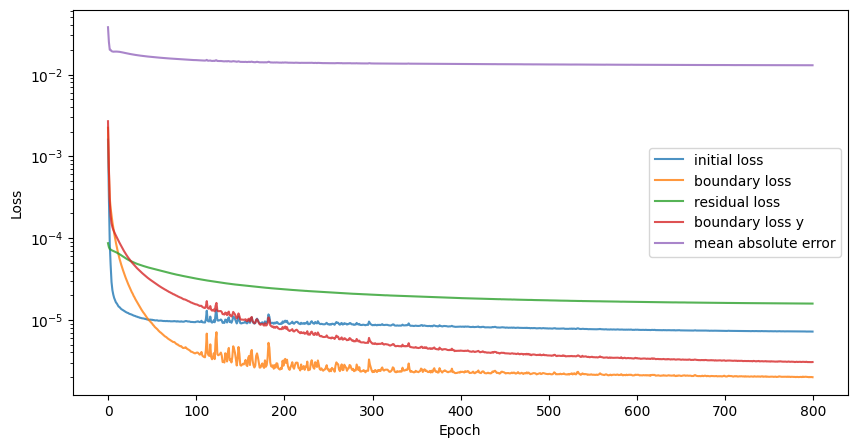

1/1 [==============================] - 0s 79ms/step
Epoch 1/800
15/15 [==============================] - 35s 25ms/step - loss_total: 0.0039 - loss_residual: 1.3810e-05 - loss_initial: 0.0010 - loss_boundary: 0.0018 - loss_boundary_y: 0.0010 - mean_absolute_error: 0.0260
Epoch 2/800
15/15 [==============================] - 0s 25ms/step - loss_total: 7.1585e-04 - loss_residual: 1.3844e-05 - loss_initial: 1.9556e-04 - loss_boundary: 2.7575e-04 - loss_boundary_y: 2.3069e-04 - mean_absolute_error: 0.0184
Epoch 3/800
15/15 [==============================] - 0s 24ms/step - loss_total: 2.3427e-04 - loss_residual: 1.4402e-05 - loss_initial: 6.1842e-05 - loss_boundary: 9.1868e-05 - loss_boundary_y: 6.6154e-05 - mean_absolute_error: 0.0140
Epoch 4/800
15/15 [==============================] - 0s 24ms/step - loss_total: 1.2002e-04 - loss_residual: 1.3441e-05 - loss_initial: 2.9092e-05 - loss_boundary: 3.4490e-05 - loss_boundary_y: 4.2995e-05 - mean_absolute_error: 0.0135
Epoch 5/800
15/15 [========

<Figure size 640x480 with 0 Axes>

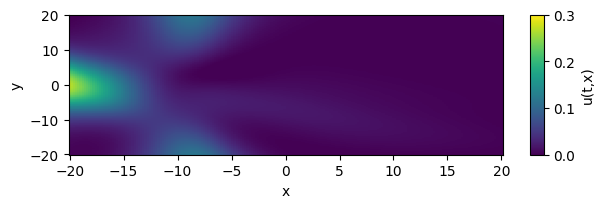

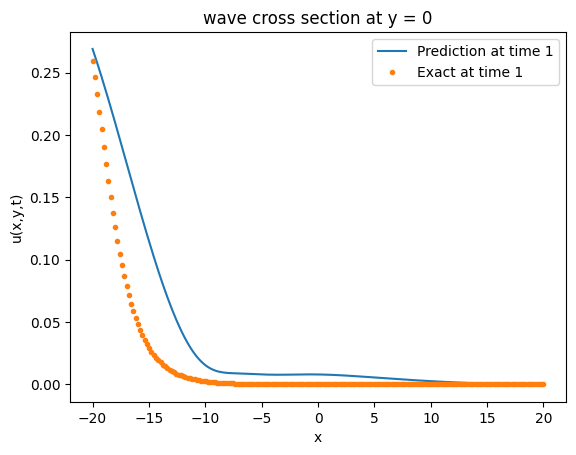

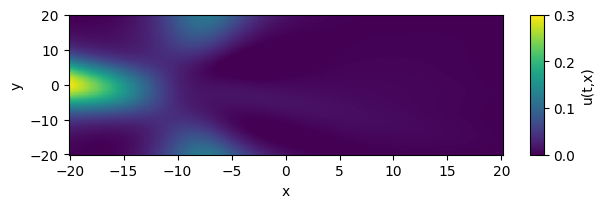

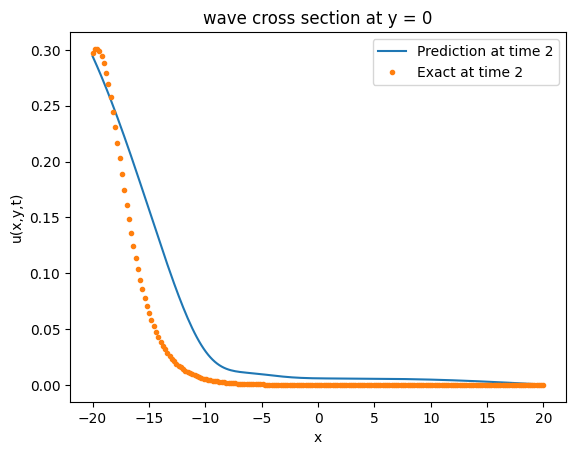

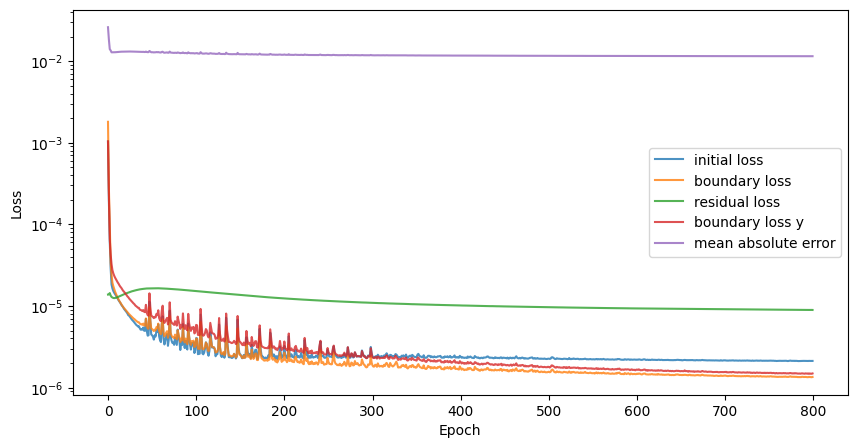

1/1 [==============================] - 0s 79ms/step
Epoch 1/800
15/15 [==============================] - 35s 24ms/step - loss_total: 0.0061 - loss_residual: 1.0094e-05 - loss_initial: 0.0017 - loss_boundary: 0.0026 - loss_boundary_y: 0.0017 - mean_absolute_error: 0.0363
Epoch 2/800
15/15 [==============================] - 0s 23ms/step - loss_total: 0.0013 - loss_residual: 8.4528e-06 - loss_initial: 3.1502e-04 - loss_boundary: 4.5546e-04 - loss_boundary_y: 4.7365e-04 - mean_absolute_error: 0.0211
Epoch 3/800
15/15 [==============================] - 0s 24ms/step - loss_total: 3.2468e-04 - loss_residual: 8.1433e-06 - loss_initial: 8.0644e-05 - loss_boundary: 1.4451e-04 - loss_boundary_y: 9.1385e-05 - mean_absolute_error: 0.0166
Epoch 4/800
15/15 [==============================] - 0s 23ms/step - loss_total: 1.3897e-04 - loss_residual: 7.9638e-06 - loss_initial: 2.3907e-05 - loss_boundary: 7.3520e-05 - loss_boundary_y: 3.3578e-05 - mean_absolute_error: 0.0149
Epoch 5/800
15/15 [============

<Figure size 640x480 with 0 Axes>

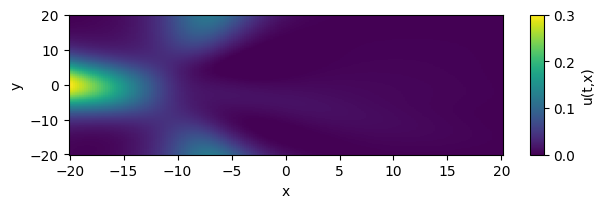

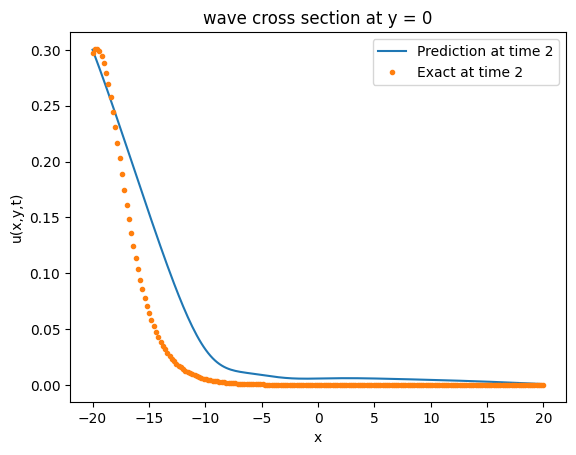

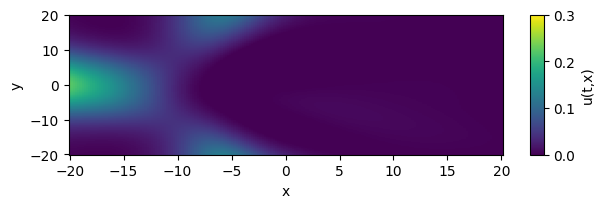

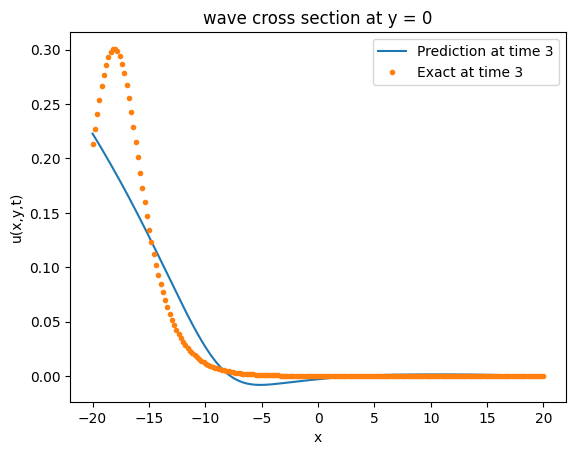

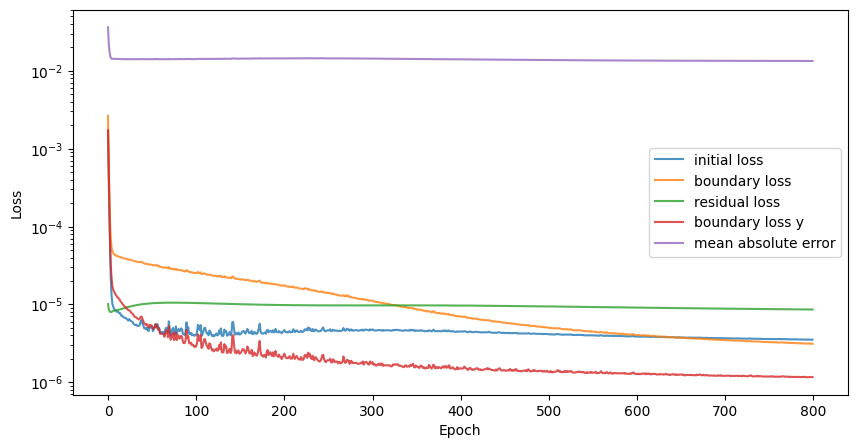

1/1 [==============================] - 0s 84ms/step
Epoch 1/800
15/15 [==============================] - 35s 25ms/step - loss_total: 0.0042 - loss_residual: 1.4602e-05 - loss_initial: 0.0013 - loss_boundary: 0.0017 - loss_boundary_y: 0.0012 - mean_absolute_error: 0.0308
Epoch 2/800
15/15 [==============================] - 0s 25ms/step - loss_total: 7.8460e-04 - loss_residual: 1.4937e-05 - loss_initial: 2.2189e-04 - loss_boundary: 2.5400e-04 - loss_boundary_y: 2.9378e-04 - mean_absolute_error: 0.0216
Epoch 3/800
15/15 [==============================] - 0s 24ms/step - loss_total: 2.5510e-04 - loss_residual: 1.6627e-05 - loss_initial: 6.5772e-05 - loss_boundary: 1.0485e-04 - loss_boundary_y: 6.7845e-05 - mean_absolute_error: 0.0202
Epoch 4/800
15/15 [==============================] - 0s 23ms/step - loss_total: 1.0128e-04 - loss_residual: 1.7105e-05 - loss_initial: 1.8923e-05 - loss_boundary: 3.8609e-05 - loss_boundary_y: 2.6639e-05 - mean_absolute_error: 0.0186
Epoch 5/800
15/15 [========

<Figure size 640x480 with 0 Axes>

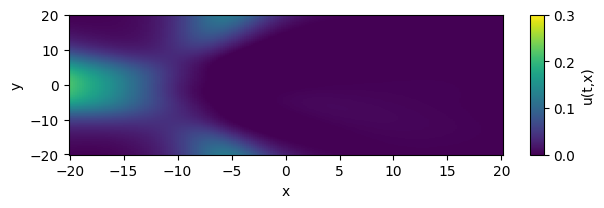

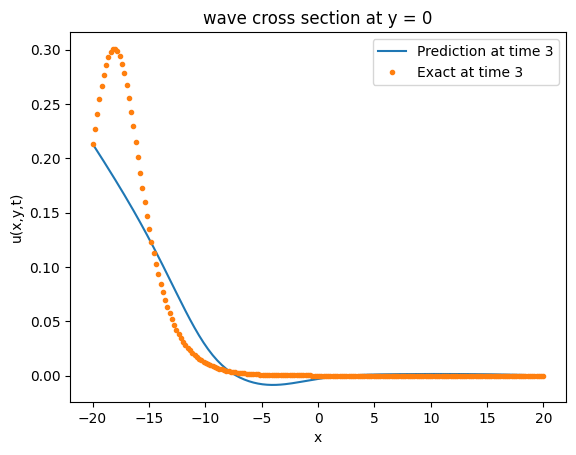

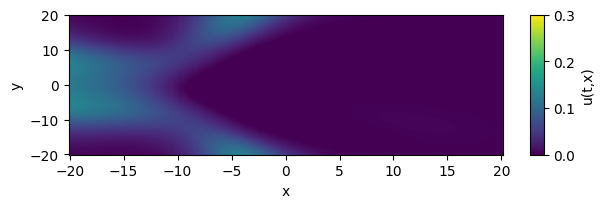

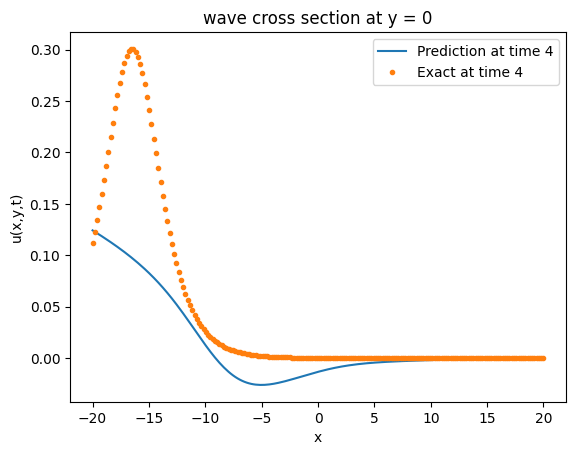

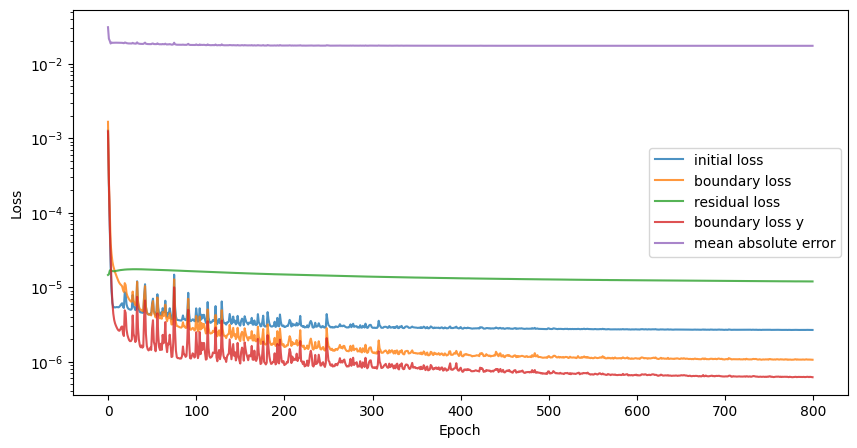

1/1 [==============================] - 0s 18ms/step


<Figure size 640x480 with 0 Axes>

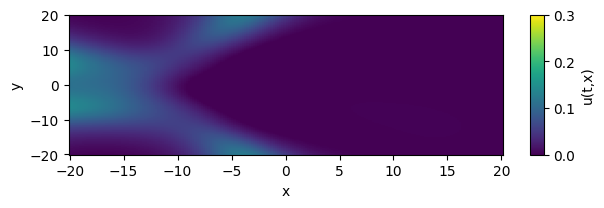

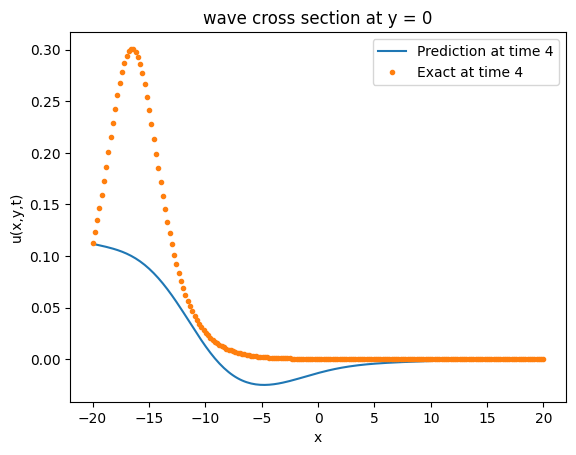

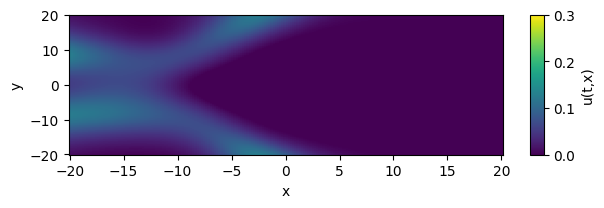

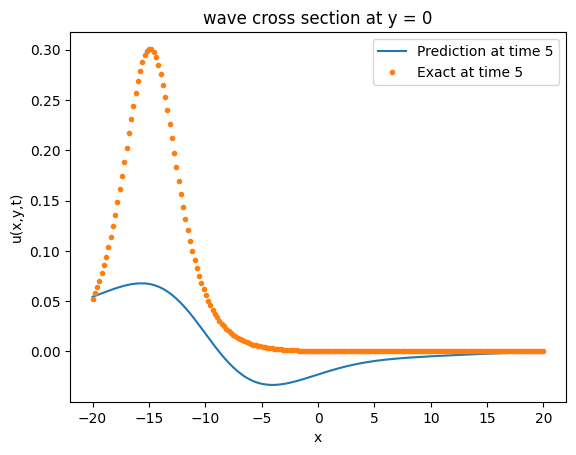

In [ ]:
for i in range(1,5):
  time = 1 + i
  (txy_eqn, u_eqn), (txy_init, u_phi), (txy_boundary_x, u_bnd_x), (txy_boundary_y, u_bnd_y), (x_bnd_left, x_bnd_right), (y_bnd_left, y_bnd_right)  = \
  simulate_KP(75000, phi_function, None, time, x_start, length, y_start, ylength, n_bnds = None, n_init = None, tstart = time-1, random_seed = 42, dtype=tf.float32)
  normalizer = tf.keras.layers.Normalization(axis=1)
  normalizer.adapt(txy_eqn)
  u_phi = pinn.backbone.predict(txy_init, batch_size=75000)
  inputs = [txy_eqn, txy_init, txy_boundary_x, x_bnd_right, x_bnd_left, txy_boundary_y, y_bnd_right, y_bnd_left]
  outputs = [phi_function(txy_eqn), u_eqn, u_phi, u_bnd_x, u_bnd_y]

  backbone = create_dense_model_Normalized([12, 24, 24, 24, 24, 12] , activation= 'tanh', initializer='glorot_normal', \
  n_inputs=3, n_outputs=1, normalizer=normalizer)
  pinn = KPPinn(backbone, k=6., sig_sq = +3., PBC_y = False)
  scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.85)
  optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
  pinn.compile(optimizer=optimizer)

  with open('KPSeq2SeqXJunction/test'+str(i-1)+'.pickle', 'rb') as f:
    my_weights = pickle.load(f)

  pinn.backbone.set_weights(my_weights)
  history = pinn.fit(inputs, outputs, batch_size = 5000, epochs = 800, verbose ='auto')


  plot_training_loss(history.history, y_scale='log')
  plt.savefig(str(os.getcwdb())[2:-1]+"/KPSeq2SeqXJunction/Loss"+str(i)+".png", format="png", bbox_inches="tight")

  plot_snapshots([i,time], cross_sect = 0)
  current_weights = pinn.backbone.get_weights()
  with open('KPSeq2SeqXJunction/test'+str(i)+'.pickle', 'wb') as f:
      pickle.dump(current_weights, f)



(1000, 3)


Text(0.5, 1.0, 'wave cross section at y = 0')

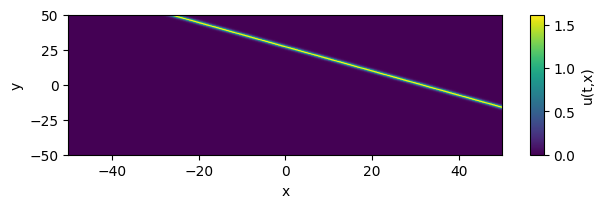

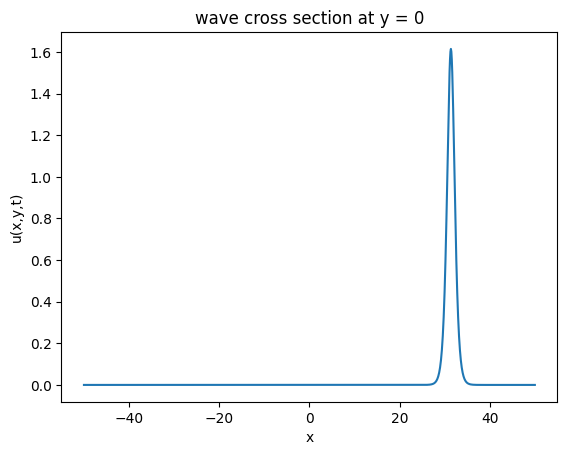

In [ ]:
ufrom matplotlib.gridspec import GridSpec
N = 1000
xt = np.linspace(x_start,length,N).T
yt = np.linspace(x_start,length,N).T
tt = np.zeros((N,1))
xt = xt.reshape(-1,1)
yt = yt.reshape(-1,1)
tt = tt.reshape(-1,1)

txy_test = np.c_[tt,xt,yt]
print(txy_test.shape)
txy_test = tf.convert_to_tensor(txy_test, dtype = 'float32')
txy_test = tf.reshape(txy_test, [N,3])
# (tf.shape(txy_test))
# plt.plot(txy_test[:,1:2], phi_function(txy_test))
TIME = 6
x, y = np.meshgrid(xt, yt)
txy = np.stack([np.full(x.flatten().shape, TIME), x.flatten(), y.flatten()],axis=-1)

fig = plt.figure(figsize=(7,4))
gs = GridSpec(2, 5)
plt.subplot(gs[0, :])

ut = phi_function(txy)
ut = tf.reshape(ut, [x.shape[0],x.shape[1]])
plt.pcolormesh(x, y, ut)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
cbar.mappable.set_clim( tf.reduce_min(ut), tf.reduce_max(ut))
fig = plt.figure()
cross_sect = 0
txy2 = np.stack([np.full(tt.shape, TIME),  xt , np.full(tt.shape, cross_sect)], axis=1)
u2 = phi_function(txy2)
u2 = tf.reshape(u2, [xt.shape[0],xt.shape[1]])
plt.plot(xt, u2, label = 'prediction at time {}'.format(0))
plt.xlabel('x')
plt.ylabel('u(x,y,t)')
plt.title('wave cross section at y = {}'.format(cross_sect))






In [ ]:
! git push origin main

Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 8 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 382.23 KiB | 11.24 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/naiaseh/Trunk
   ed60ad1..45792a1  main -> main
